# *PathReducer* Walkthrough

## The example detailed in this notebook is the first system examined in [this paper](https://doi.org/10.26434/chemrxiv.8089208.v2). Mathematical details and further discussion of results can also be found therein.

_PathReducer_ is a Python package meant to help chemistry researchers who may have less experience with programming generate reduced dimensional spaces for their systems of interest. Generating an optimal reduced dimensional space for a particular chemical system is useful in a variety of realms, particularly for defining pathways in biased MD simulations. For now, we will just be focusing on the generation and visualization of an intrinsic reaction coordinate (IRC) calculation in reduced dimensional spaces.

First off, let's get the necessary imports out of the way, and then we'll move on to an example system whose dimensionality we will reduce. 

In [2]:
%matplotlib notebook

In [3]:
import sys, os
import pandas as pd

In [4]:
import dimensionality_reduction_functions as dim_red

### Malonaldehyde H-Transfer IRC Example

The reaction pathway we are going to be analyzing is the intrinsic reaction coordinate (IRC) for the intramolecular proton transfer of malonaldehyde. 

<font color=white>__</font>|<font color=white>__</font>
:- | :-
  |  
![MalonaldehydeIRC](PathReducer_Walkthrough_I_gifs/malonaldehyde_IRC_delay8.gif "Malonaldehyde IRC") | ![MalonaldehydeIRCPlot](PathReducer_Walkthrough_I_gifs/small_scatterline_plot.gif "Malonaldehyde IRC Plot")
  | 

There are 25 structures along this IRC. In the plot above (right), each scatter point references a particular structure along the IRC. While an IRC can already be thought of as a reduced dimensional (2-D) representation of a molecular system's potential energy surface ((3N-6)-D) in coordinate space, the IRC is not a well-defined coordinate. Structures along an IRC are along the steepest descent path from a saddle point on a potential energy surface to its two flanking minima, and can make many twists and turns along the way without following a single linear coordinate. _PathReducer_ can decouple the linear coordinates that make up the IRC, to get information about the specific geometric changes necessary for a particular transformation.  

These gifs are synced such that the point corresponding to the structure shown on the left is circled on the IRC plot. Purple scatter points correspond to the structures at the beginning of a file and yellow are structures at the end. This color scheme will be used for plots throughout, and will help to differentiate the beginning and end of IRCs and trajectories in the plots of principal components (PCs) we generate. 

### _PathReducer_ Usage
As input to _PathReducer_, the first thing we need to specify is the path to our xyz file of interest (in this case, the xyz file that contains the structures along the malonaldehyde IRC). This can be either an absolute or relative path to the file of interest, as a string (i.e., in quotes). 

We also must specify the number of PCs we are interested in generating. Note that specifying different numbers of PCs does _not_ change the identities of the PCs, as the procedure for PCA is not changing. The only output this affects is how many xyz files of PCs are back transformed into the full dimensional space of the original input data.  

We have also specified a list of four atoms to define the chirality of each of the structures in my xyz file (`stereo_atoms_malon`, below). Note that these are atom numbers, not indices, which start at 1 (not 0). The reason these atoms must be specified is that, when defining structures as their squared interatomic distances, we lose information about the chirality of the molecule, and thus when Cartesian coordinates are reconstructed from squared interatomic distances (in the output xyz files), we need a connection to the chirality of the input structures. _PathReducer_ uses these four specified atoms in a calculation that results in either a positive or negative number that defines the chirality of each structure; then, when back-transforming the structures from PC space into the full dimensional space, these signs are used to determine the chirality of the reconstructed molecuar geometries. 

See the paper linked above for details.

In [5]:
ndim = 2
path = 'examples/malonaldehyde/malonaldehyde_IRC.xyz'
stereo_atoms_malon = [4, 7, 1, 8]

You may (correctly) notice that malonaldehyde is not actually chiral, and so this specification is a bit confusing. While malonaldehyde has a plane of symmetry that lies in the plane of your computer screen (as I've oriented the gif, above), and this plane of symmetry is not broken throughout the IRC, it _may_ be broken along one or more of the PCs. When you open one of the output PC xyz files, you will be able to tell if your stereo_atoms were well-chosen based on the continuity of the resultant structures. As such, their definition may take some trial and error.

And now we are ready to run pathreducer with these inputs! We also must specify the input_type in the function call, which tells pathreducer how to represent each molecular structure prior to doing PCA. First, we'll look at representing each structure as a matrix of squared interatomic distances by specifying the `input_type` to be `"Distances"`. 

In [6]:
system_name, output_directory, pca, pca_fit, pca_components, mean, values, traj_lengths, aligned_original_coords = \
    dim_red.pathreducer(path, ndim, stereo_atoms=stereo_atoms_malon, input_type="Distances")


Input is one file.
File being read is: malonaldehyde_IRC.xyz
Results for examples/malonaldehyde/malonaldehyde_IRC.xyz input will be stored in malonaldehyde_IRC_Distances_noMW_output

(1D) Generation of distance matrices and reshaping upper triangles into vectors done!

(2) Done with PCA of structures as distance matrices!

(3) Done transforming reduced dimensional representation of input into full dimensional space!

(4D)-(6D) Done with converting distance matrices back to Cartesian coordinates!

(7D) Done checking chirality of resultant structures!

(8D) Done aligning!

Done generating output!


/Users/ec18006/Documents/Documents/CHAMPS/Dimensionality_reduction/github_repos/PathReducer/dimensionality_reduction_functions.py:216: RuntimeWarning: invalid value encountered in sqrt
  coords = np.dot(vectors, np.diag(np.sqrt(values)))


An output directory (in this case called `"malonaldehyde_IRC_Distances_noMW_output"`, but will be named based on your system name and the way you define your molecular structures) has now been generated that stores all the output from _PathReducer_.

Next, we can plot the PCs to see what the IRC path looks like in a reduced dimensional space using _PathReducer_'s plotting functions. For ease, I've put the matrix of PCs into a pandas DataFrame. Note that you can rotate the 3D plot generated below!

<IPython.core.display.Javascript object>


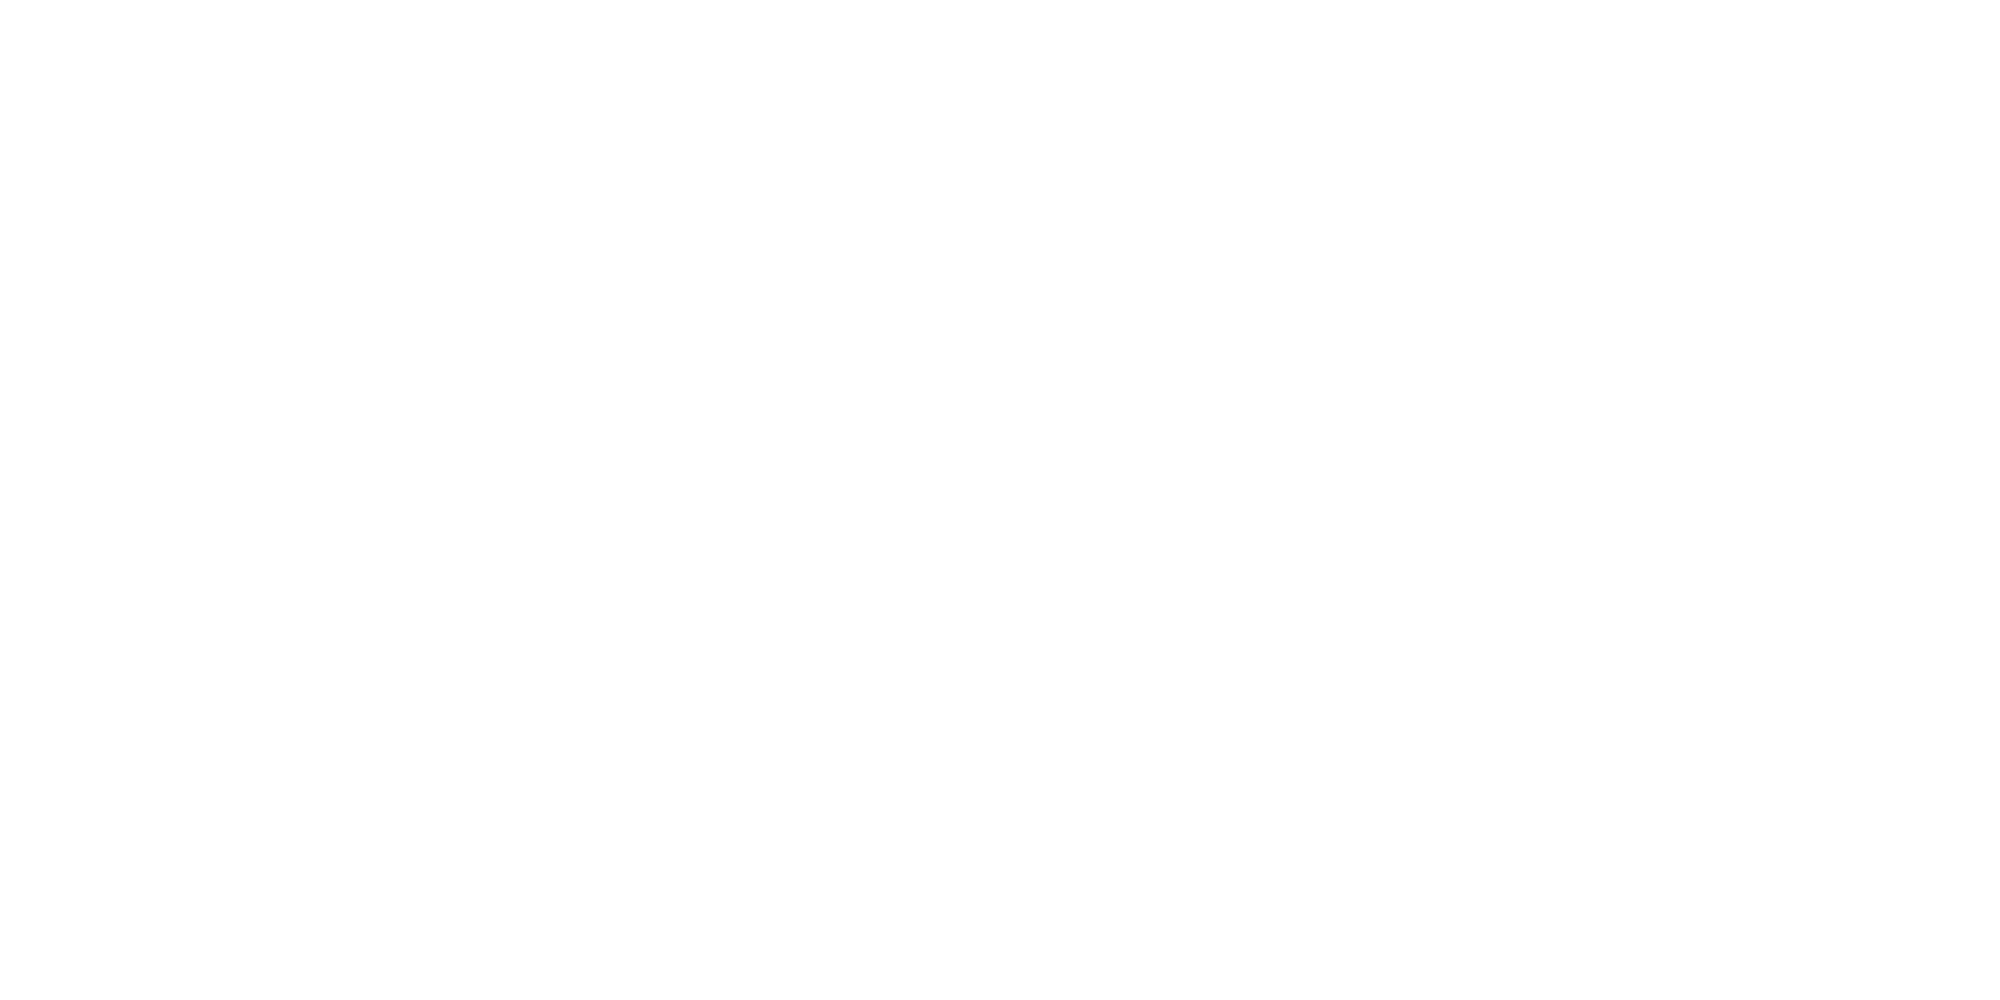

In [7]:
pca_df = pd.DataFrame(pca)
dim_red.plotting_functions.colored_line_and_scatter_plot(pca_df[0], pca_df[1], pca_df[2])

This particular plotting function also has the ability to circle points of interest by setting the `points_to_circle` input variable to a list of points (these are pythonic indices, so they start at 0, not 1). Let's circle the reactant, transition state, and product structures.

<IPython.core.display.Javascript object>


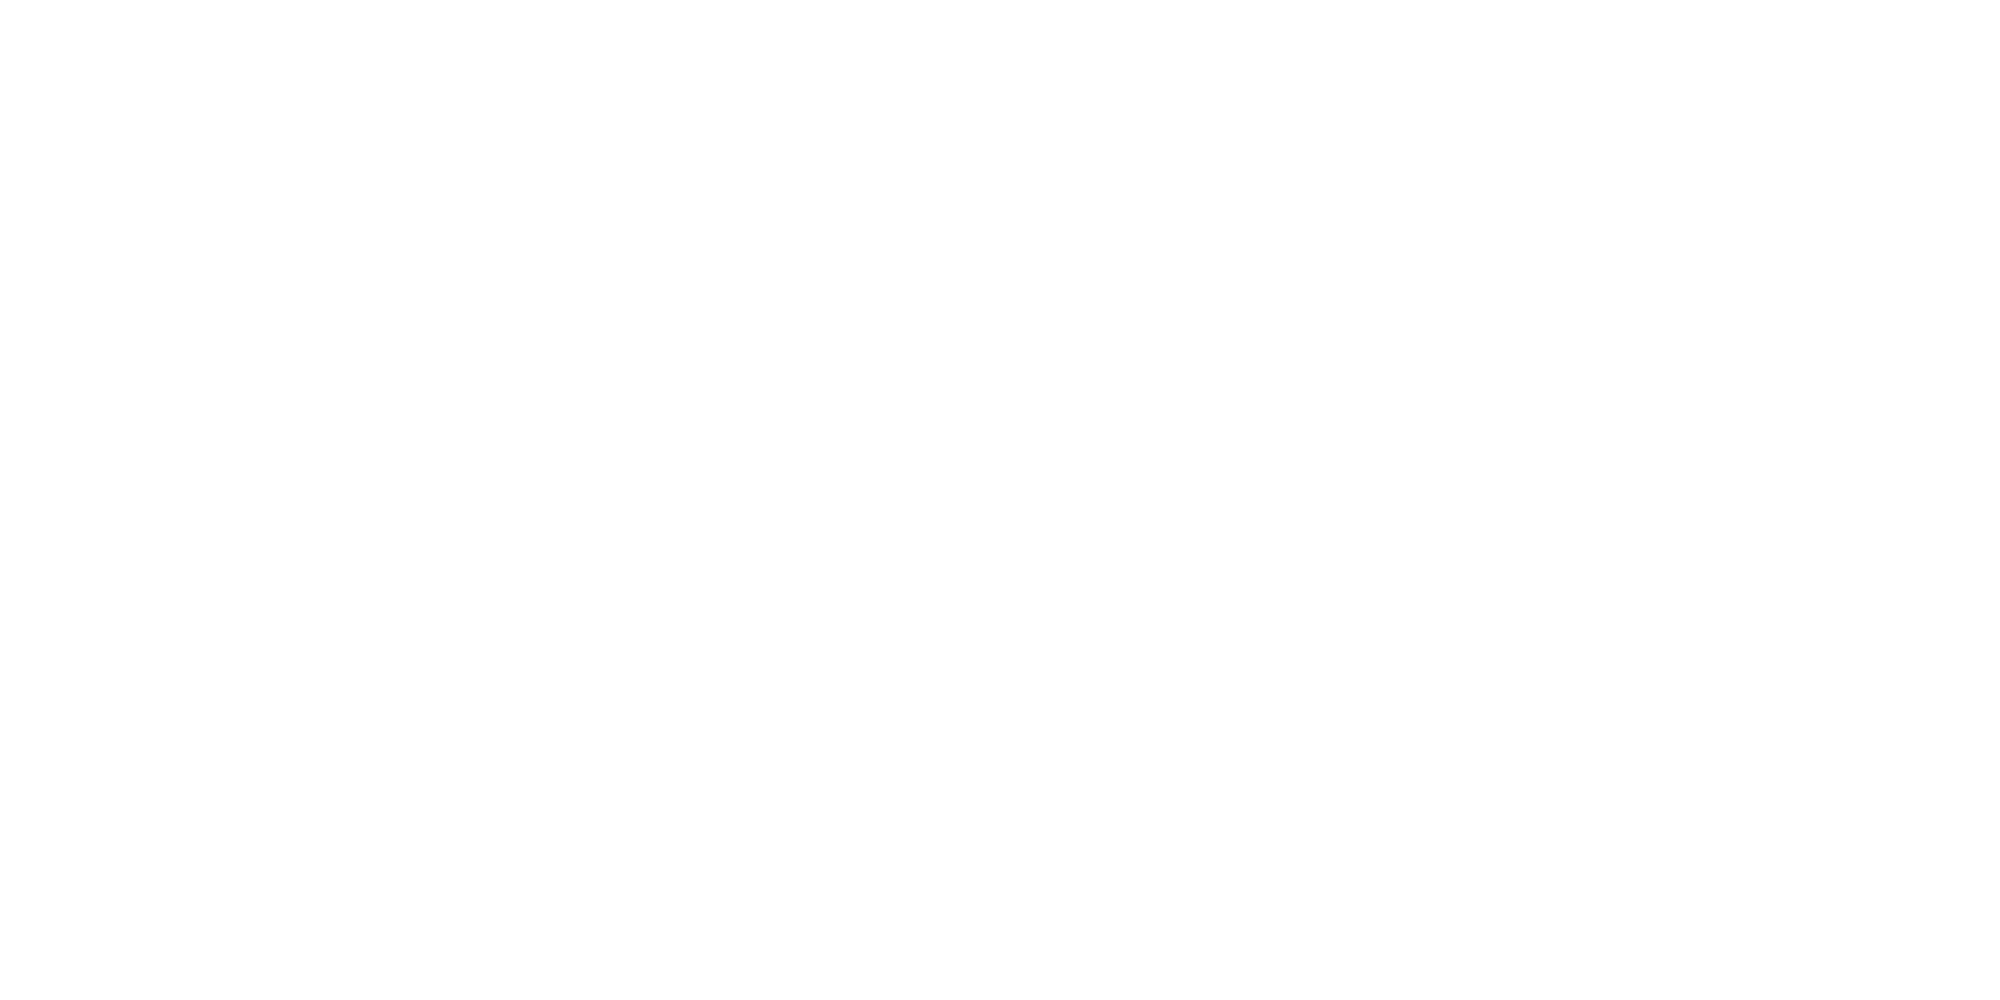

In [8]:
points_to_circle = [0, 12, 24]
dim_red.plotting_functions.colored_line_and_scatter_plot(pca_df[0], pca_df[1], pca_df[2], points_to_circle=points_to_circle)

We can also plot the proportion of variance described by each PC, and see how the proportion of variance described accumulates by adding more PCs. By adding `system_name=system_name` and `output_directory=output_directory` to the function call, this plot can be saved as a png in the output directory (or you can specify whatever name/directory you would like and not use the `system_name` and `output_directory` defined above by _PathReducer_ ).

<IPython.core.display.Javascript object>


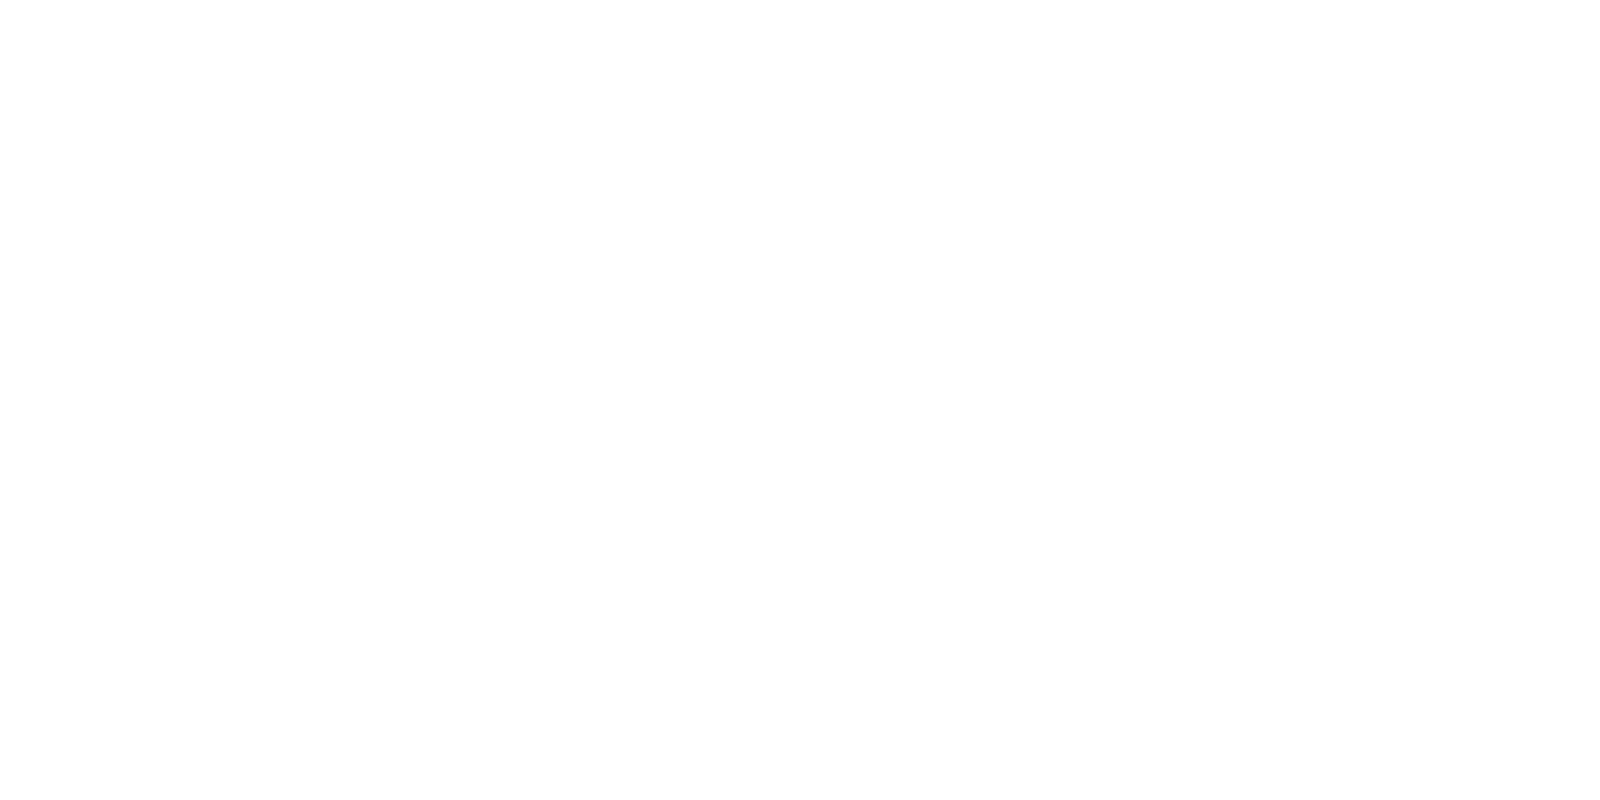

In [9]:
dim_red.plotting_functions.plot_prop_of_var(values)

xyz files of PC1 and PC2 will be in the specified `output_directory`. They look like the following:

<font color=black>PC1</font>|<font color=black>PC2</font>
:- | :-
  |  
![MalonaldehydePC1](PathReducer_Walkthrough_I_gifs/malon_PC1_delay8.gif "Malonaldehyde PC1") | ![MalonaldehydePC2](PathReducer_Walkthrough_I_gifs/malon_PC2_delay8.gif "Malonaldehyde PC2")
  | 

These gifs show PC1 and PC2 in the space defined by the original IRC structures. If we were interested in seeing what the _directions_ of these PCs correspond to, _PathReducer_ has the ability to take the mean structure of the input data and distort the geometry of this structure in these directions (if you're familiar with GaussView, this is similar to viewing vibrational modes, hence the name of this _PathReducer_ function). This is done by setting the `normal_modes` flag in the initial pathreducer function call to `True`. 

In [10]:
system_name, output_directory, pca, pca_fit, pca_components, mean, values, lengths, aligned_original_coords = \
    dim_red.pathreducer(path, 3, input_type="Distances", stereo_atoms=stereo_atoms_malon, normal_modes=True)


Input is one file.
File being read is: malonaldehyde_IRC.xyz
Results for examples/malonaldehyde/malonaldehyde_IRC.xyz input will be stored in malonaldehyde_IRC_Distances_noMW_output

(1D) Generation of distance matrices and reshaping upper triangles into vectors done!

(2) Done with PCA of structures as distance matrices!

(3) Done transforming reduced dimensional representation of input into full dimensional space!

(4D)-(6D) Done with converting distance matrices back to Cartesian coordinates!

(7D) Done checking chirality of resultant structures!

(8D) Done aligning!

Done generating output!


/Users/ec18006/Documents/Documents/CHAMPS/Dimensionality_reduction/github_repos/PathReducer/dimensionality_reduction_functions.py:216: RuntimeWarning: invalid value encountered in sqrt
  coords = np.dot(vectors, np.diag(np.sqrt(values)))


<font color=black>Direction of PC1 as a normal mode</font>|<font color=black>Direction of PC2 as a normal mode</font>
:- | :-
  |  
![MalonaldehydePC1normalmode](PathReducer_Walkthrough_I_gifs/malon_PC1_normal_mode_delay8.gif "Malonaldehyde PC1 normal mode") | ![MalonaldehydePC2normalmode](PathReducer_Walkthrough_I_gifs/malon_PC2_normal_mode_delay8.gif "Malonaldehyde PC2 normal mode")
  | 

We can also see what happens to our PCs when we mass-weight our Cartesian coordinates prior to defining structures as interatomic distances matrices by adding `mw=True` to the `pathreducer` function call.

In [12]:
system_name, output_directory, pca, pca_fit, components, mean, values, traj_lengths, aligned_original_coords = \
    dim_red.pathreducer(path, ndim, stereo_atoms=stereo_atoms_malon, input_type="Distances", mw=True)


Input is one file.
File being read is: malonaldehyde_IRC.xyz
Results for examples/malonaldehyde/malonaldehyde_IRC.xyz input will be stored in malonaldehyde_IRC_Distances_MW_output

(MW) Done mass-weighting coordinates!

(1D) Generation of distance matrices and reshaping upper triangles into vectors done!

(2) Done with PCA of structures as distance matrices!

(3) Done transforming reduced dimensional representation of input into full dimensional space!

(4D)-(6D) Done with converting distance matrices back to Cartesian coordinates!

(UMW) Done removing mass-weighting!

(7D) Done checking chirality of resultant structures!

(8D) Done aligning!

Done generating output!


/Users/ec18006/Documents/Documents/CHAMPS/Dimensionality_reduction/github_repos/PathReducer/dimensionality_reduction_functions.py:216: RuntimeWarning: invalid value encountered in sqrt
  coords = np.dot(vectors, np.diag(np.sqrt(values)))


Plotting the results...

<IPython.core.display.Javascript object>


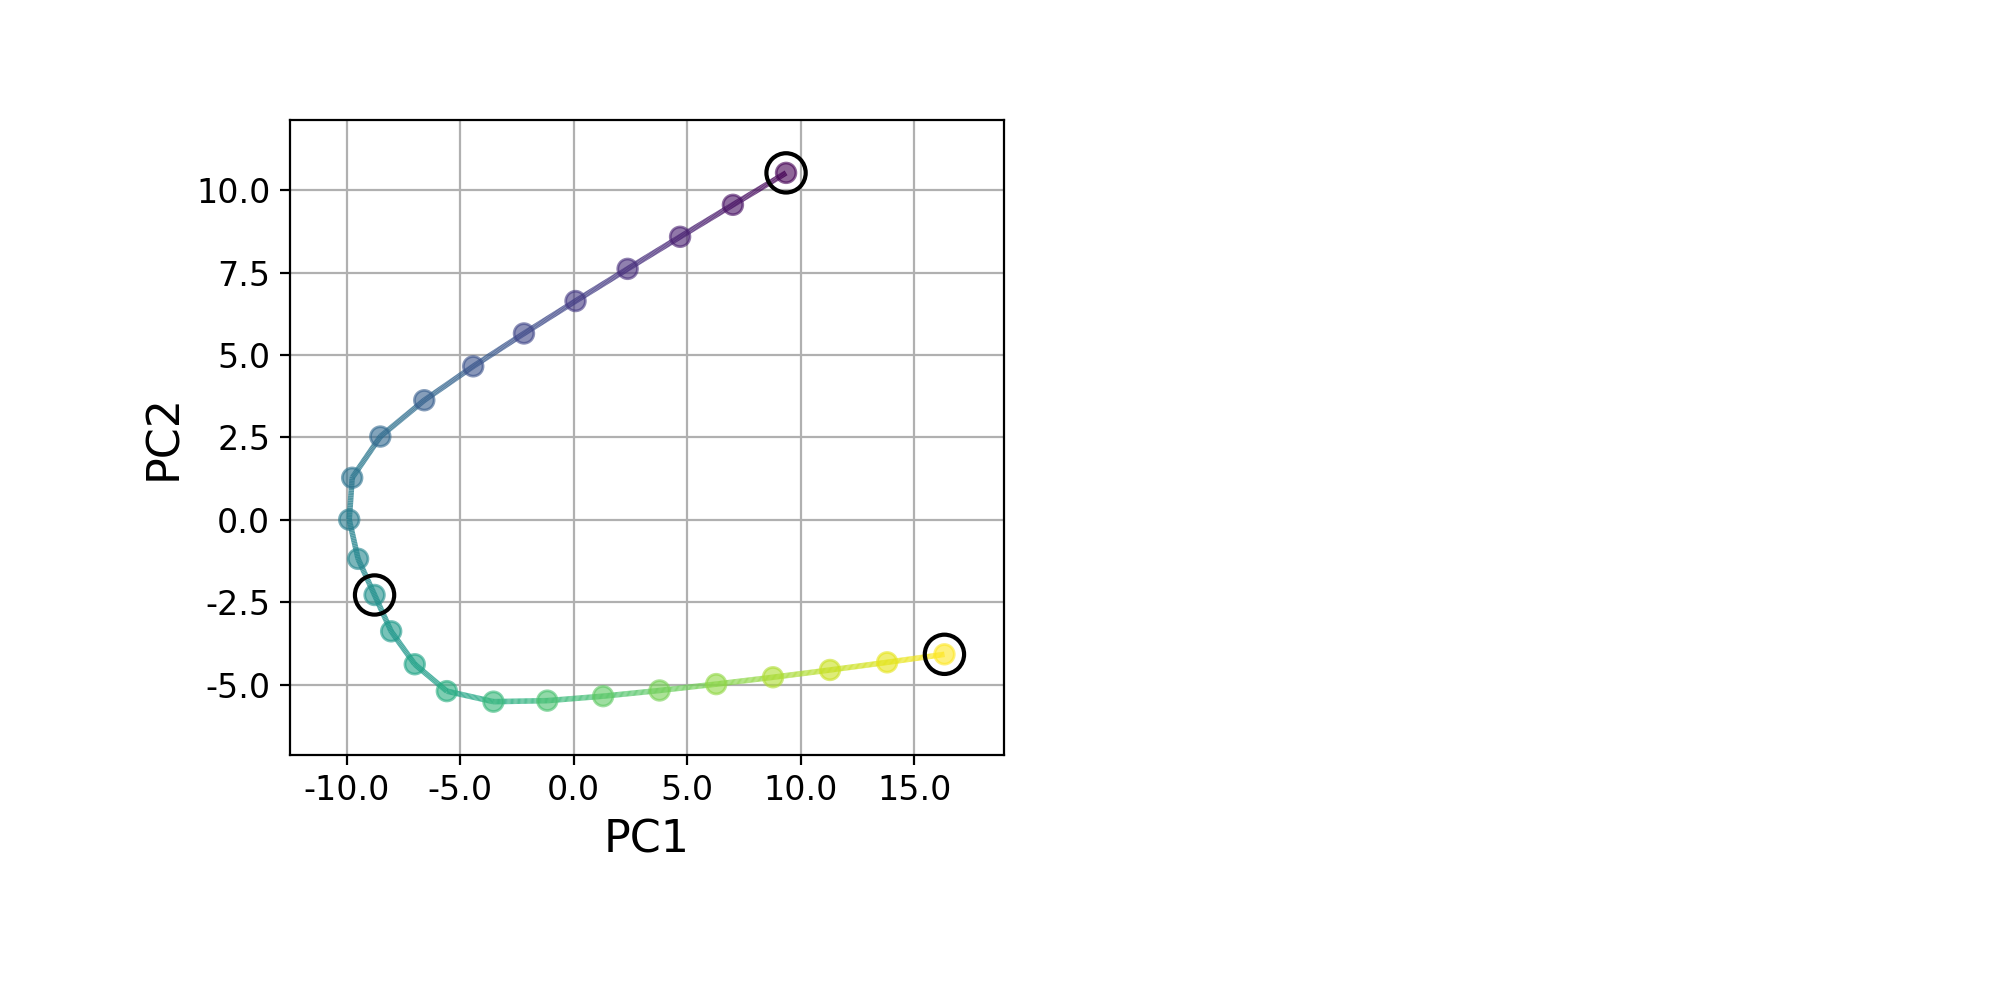

In [13]:
pca_df = pd.DataFrame(pca)
dim_red.plotting_functions.colored_line_and_scatter_plot(pca_df[0], pca_df[1], pca_df[2], points_to_circle=points_to_circle)

Interestingly, this seems to have rotated our plot and changed the values of PC1 and PC2. This is because mass-weighting causes movements by H-atoms to be dwarfed by movements of heavy atoms. Since mass-weighting is done to the Cartesian coordinates prior to generating squared interatomic distance matrices, this effect is especially pronounced here and PC1 and PC2 likely look quite different compared to the previous case. In fact, mass-weighted PC1 appears to somehow combine the atomic movements represented by non-mass-weighted PC1 and PC2. 

<font color=black>PC1</font>|<font color=black>PC2</font>
:- | :-
  |  
![MalonaldehydeMWPC1](PathReducer_Walkthrough_I_gifs/malon_mw_PC1_delay8.gif "Malonaldehyde MW PC1") | ![MalonaldehydeMWPC2](PathReducer_Walkthrough_I_gifs/malon_mw_PC2_delay8.gif "Malonaldehyde MW PC2")
  | 

Lastly, we'll take a quick look at the PCA results if we simply represent our structures as Cartesian coordinates rather than interatomic distances. This is accomplished by using the workflow above, but with `input_type="Cartesians"` in the `pathreducer` function call. 

In [12]:
system_name, output_directory, pca, pca_fit, components, mean, values, traj_lengths, aligned_original_coords = \
    dim_red.pathreducer(path, ndim, input_type="Cartesians")


Input is one file.
File being read is: malonaldehyde_IRC.xyz
Results for examples/malonaldehyde/malonaldehyde_IRC.xyz input will be stored in malonaldehyde_IRC_Cartesians_noMW_output

(1C) Done aligning structures using Kabsch algorithm

(2) Done with PCA of Cartesian coordinates!

(3) Done transforming reduced dimensional representation of input into full dimensional space!

(4) Done with making output xyz files!


<IPython.core.display.Javascript object>


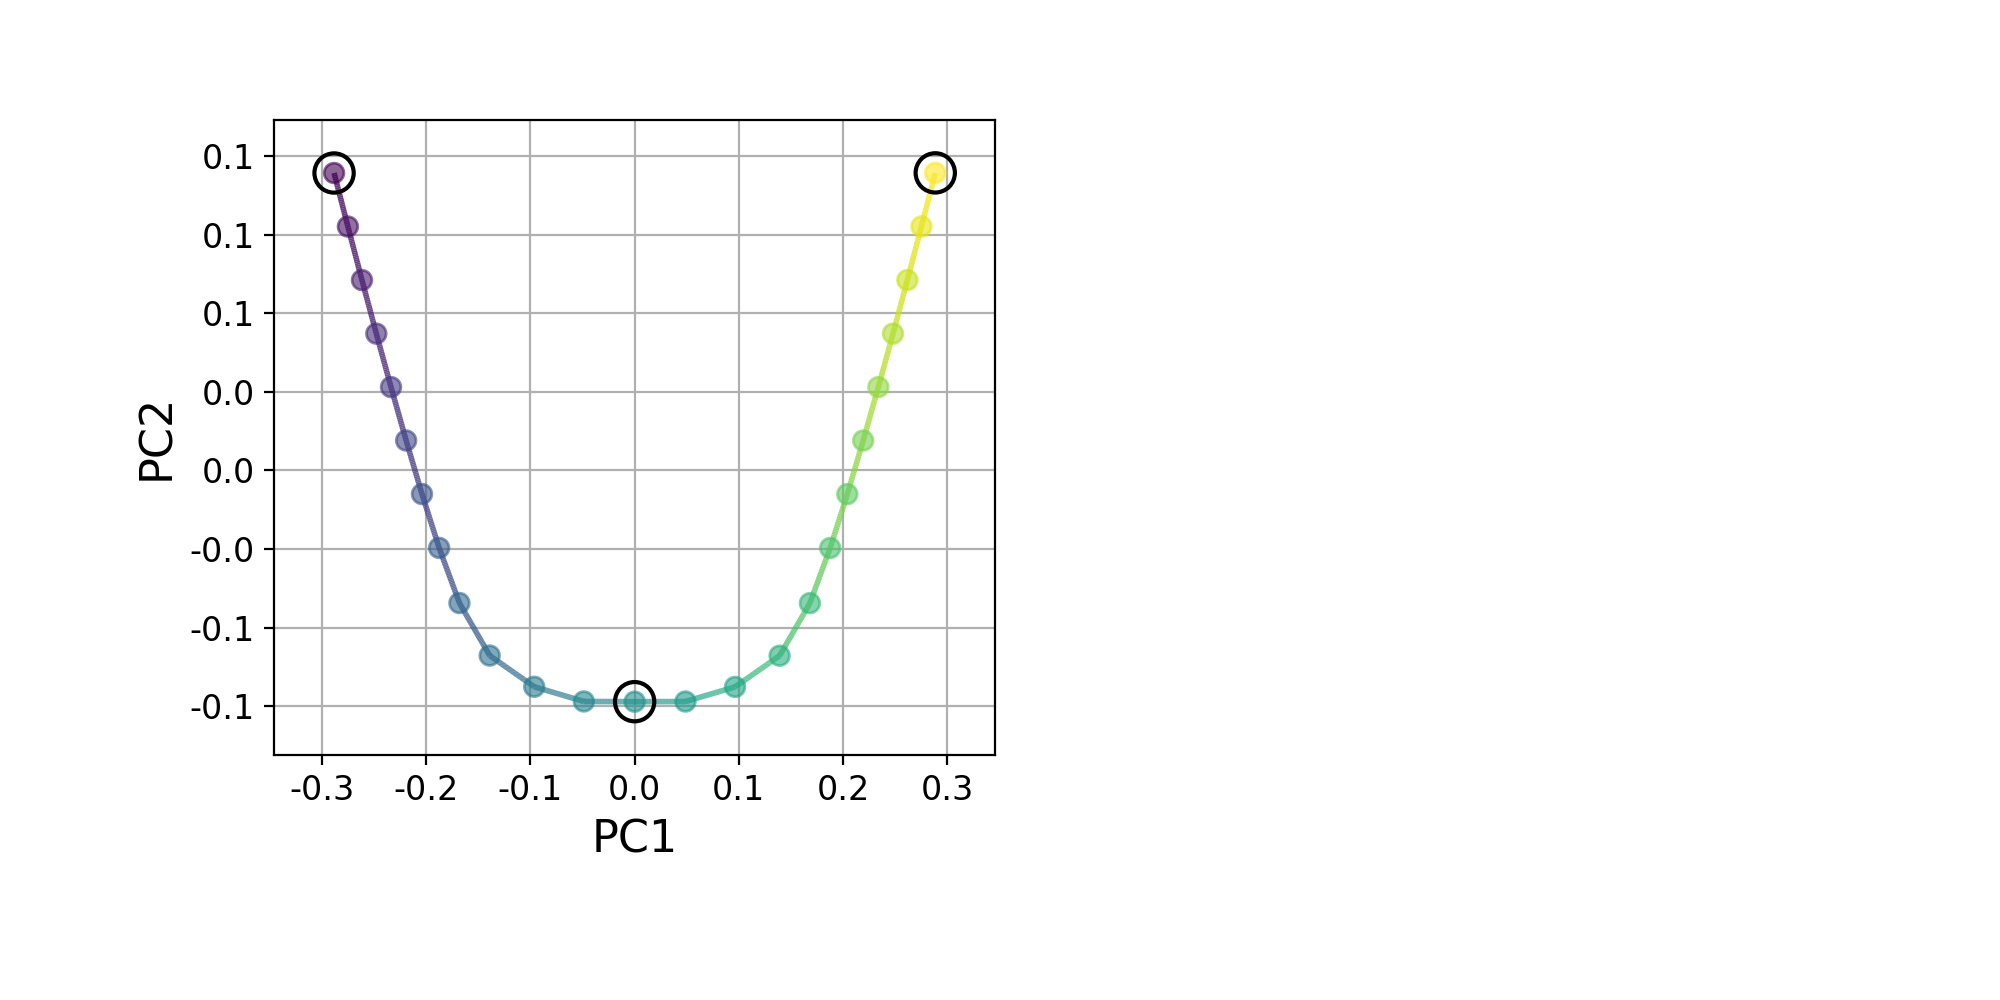

In [13]:
pca_df = pd.DataFrame(pca)
dim_red.plotting_functions.colored_line_and_scatter_plot(pca_df[0], pca_df[1], pca_df[2], points_to_circle=points_to_circle)

Finally, let's see what happens when we mass-weight these Cartesian coordinates.

In [ ]:
system_name, output_directory, pca, pca_fit, components, mean, values, traj_lengths, aligned_original_coords = \
    dim_red.pathreducer(path, ndim, input_type="Cartesians", mw=True)

<IPython.core.display.Javascript object>


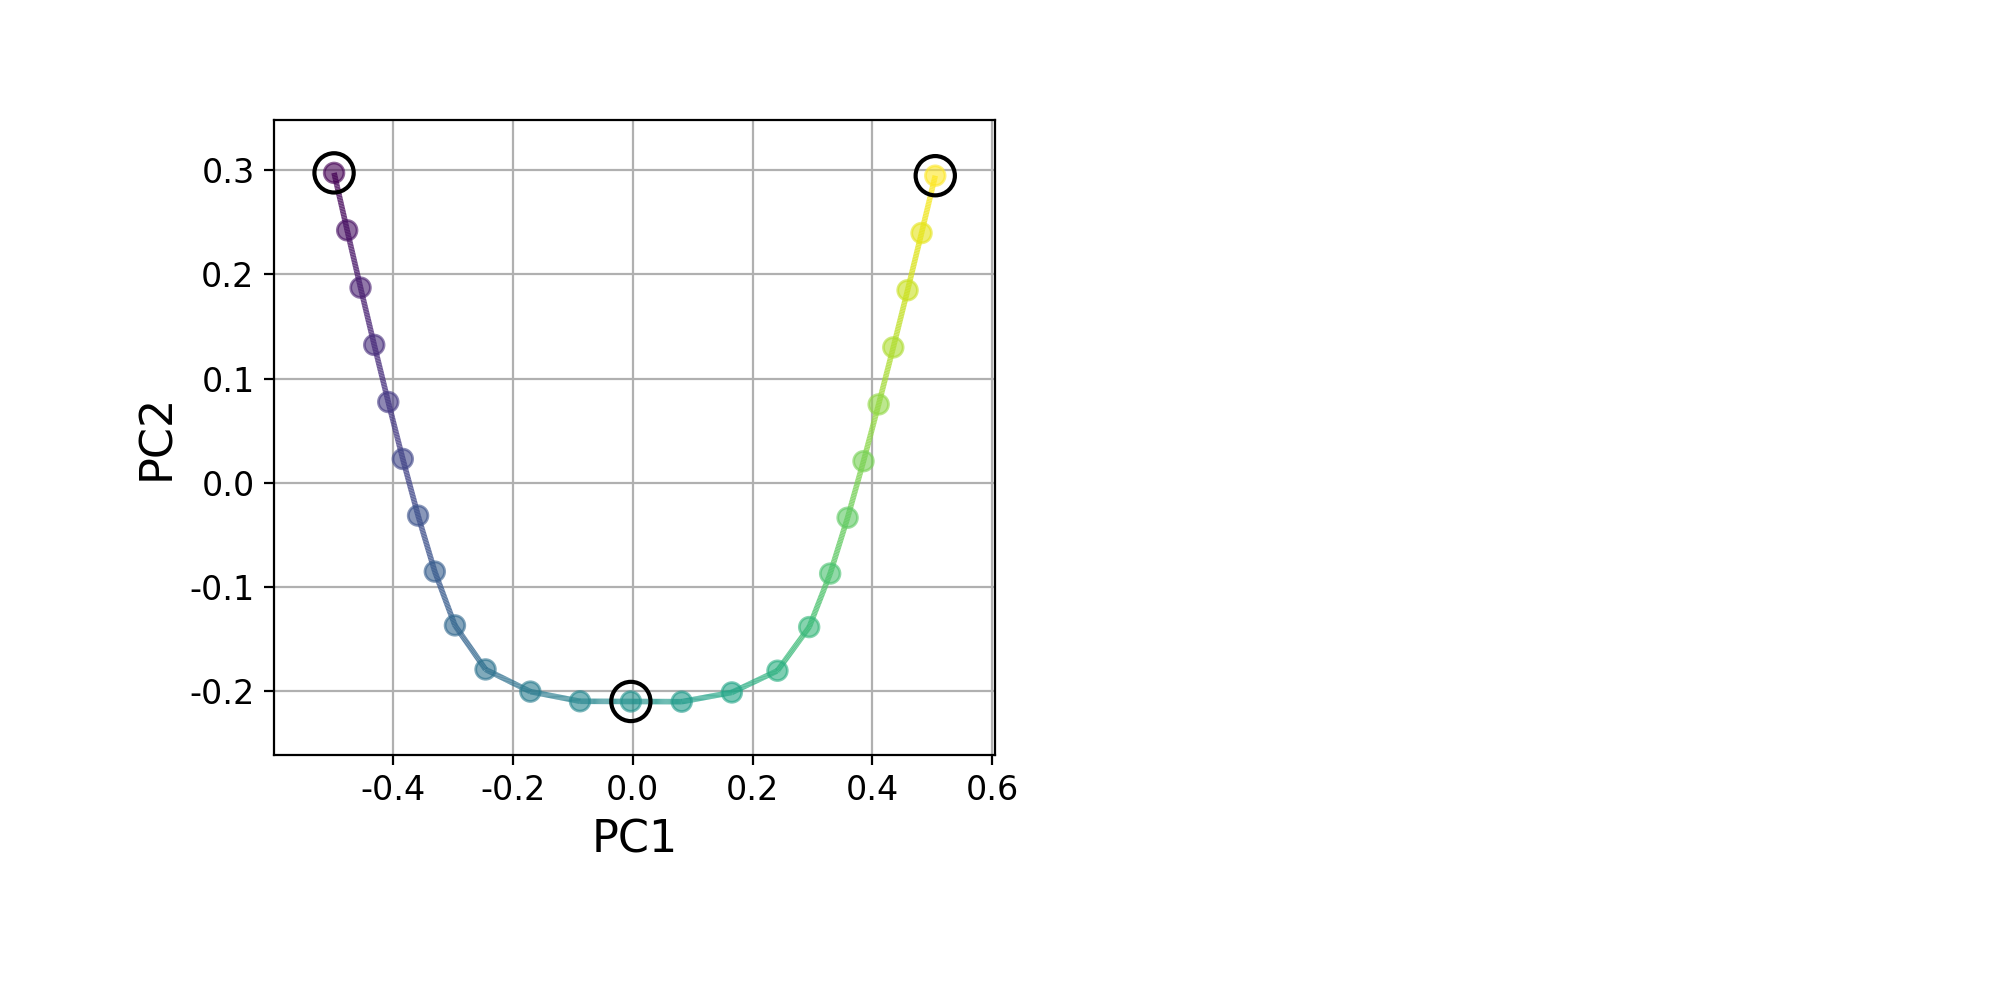

In [15]:
pca_df = pd.DataFrame(pca)
dim_red.plotting_functions.colored_line_and_scatter_plot(pca_df[0], pca_df[1], pca_df[2], points_to_circle=points_to_circle)

Mass-weighting in this case seems to only affect the magnitudes of each PC, rather than the shape of the plot. This is likely because mass-weighting Cartesian coordinates prior to turning them into squared interatomic distances causes the mass-weighting effect to be more pronounced. 